In [ ]:
import pandas as pd

df = pd.read_excel('data.xlsx')

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=214)


Мы строим модель для регрессии показателя SI (Selectivity Index), который показывает, насколько соединение избирательно подавляет вирус по сравнению с токсичностью для клеток. Чем выше SI, тем лучше. Задача регрессии позволяет предсказывать SI на основе химических дескрипторов молекул, чтобы ускорить процесс отбора перспективных соединений.

In [ ]:
X = df.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'Unnamed: 0'])

y = df['SI']


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X) # Импутация пропусков медианой


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)#Масштабирование данных


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [ ]:
import numpy as np

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_log)
y_pred_log_rf = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train_log)
y_pred_log_xgb = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name}:\n  MAE = {mae:.4f}\n  RMSE = {rmse:.4f}\n  R² = {r2:.4f}\n")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


Random Forest:
  MAE = 177.2476
  RMSE = 1414.6144
  R² = 0.0038

XGBoost:
  MAE = 178.7076
  RMSE = 1419.0392
  R² = -0.0025



Обе модели продемонстрировали высокие значения средней и среднеквадратичной ошибки, что указывает на значительные расхождения между фактическими и предсказанными значениями SI. Коэффициент детерминации R² оказался близким к нулю, а для XGBoost даже отрицательным, что говорит о неспособности моделей объяснять вариабельность данных на тестовой выборке. Это может свидетельствовать о том, что показатель SI трудно предсказывать на основе текущих признаков, либо данные требуют дополнительной обработки - например, отбора информативных признаков или устранения выбросов. Кроме того, возможно, что на значение SI существенно влияют скрытые факторы, такие как специфические характеристики молекулярной структуры, которые не отражены в предоставленных дескрипторах.

Если на графике видно, что при увеличении признака SI растёт - значит, этот признак положительно влияет на SI.
Если SI падает при росте признака - признак влияет отрицательно.
Если точек много, но они хаотично расположены — признак почти не влияет на SI. Это пояснение к графу ниже

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("Анализ связей между отдельными признаками и целевой переменной SI:")
print("Ниже представлены коэффициенты корреляции и scatter plot’ы для каждого признака.")
print("Чем выше модуль коэффициента корреляции, тем сильнее взаимосвязь между признаком и SI.")

# корреляции в словарь
correlations = {}

for col in X.columns:
    corr = df[col].corr(y)
    correlations[col] = corr
    print(f"Признак: {col}\tКоэффициент корреляции с SI: {corr:.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(df[col], y, alpha=0.6, color='purple')
    plt.xlabel(col)
    plt.ylabel('SI')
    plt.title(f'Scatter plot: {col} vs SI (corr = {corr:.4f})')
    plt.grid(True)
    plt.show()

# таблица корреляций
correlations_df = pd.DataFrame({
    'Feature': correlations.keys(),
    'Correlation with SI': correlations.values()
})

# Добавляем колонку с абсолютным значением для сортировки
correlations_df['|Correlation|'] = correlations_df['Correlation with SI'].abs()

# по убыванию модуля корреляции
correlations_df.sort_values(by='|Correlation|', ascending=False, inplace=True)

print("\nТаблица коэффициентов корреляции (отсортирована по убыванию модуля):")
display(correlations_df[['Feature', 'Correlation with SI']])

# тепловая карта
plt.figure(figsize=(10, len(correlations_df) // 2))
sns.heatmap(correlations_df.set_index('Feature')[['Correlation with SI']], annot=True, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций признаков с SI')
plt.show()



Анализ коэффициентов корреляции показал, что ни один из признаков не имеет сильной связи с целевой переменной SI. Максимальные значения корреляции находятся в диапазоне от 0.10 до 0.16, что указывает на слабую линейную зависимость между отдельными признаками и SI. Наибольшая положительная корреляция наблюдается у признака BalabanJ (0.16), который характеризует топологическую структуру молекулы, а также у признака fr_NH2 (0.16), связанного с аминогруппами. Признак RingCount демонстрирует отрицательную корреляцию (-0.12), что говорит о слабой отрицательной связи между количеством колец в молекуле и значением SI.

Большинство признаков имеют коэффициенты корреляции, близкие к нулю, что свидетельствует об отсутствии выраженной линейной зависимости. Это означает, что предсказание SI исключительно на основе линейных взаимосвязей между признаками затруднено. Вероятно, SI формируется под влиянием комплексных факторов, включая взаимодействие между признаками, нелинейные зависимости или скрытые характеристики молекул, которые не учтены в текущем наборе данных. Для улучшения модели стоит рассмотреть более сложные алгоритмы (например, ансамбли моделей, нейронные сети)

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)

# XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)


In [ ]:
ensemble_model = VotingRegressor(
    estimators=[
        ('RandomForest', rf_model),
        ('Ridge', ridge_model),
        ('XGBoost', xgb_model)
    ]
)
# Voting Regressor
ensemble_model.fit(X_train, y_train_log)  # используем логарифмированные данные


VotingRegressor(estimators=[('RandomForest',
                             RandomForestRegressor(random_state=42)),
                            ('Ridge', Ridge()),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=200,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))])

In [ ]:
y_pred_log_ensemble = ensemble_model.predict(X_test)
y_pred_ensemble = np.expm1(y_pred_log_ensemble)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2 = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble Voting Regressor:")
print(f"  MAE = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  R² = {r2:.4f}")


Ensemble Voting Regressor:
  MAE = 178.6890
  RMSE = 1419.6454
  R² = -0.0033


Ансамблевая модель Voting Regressor объединила Random Forest, Ridge Regression и XGBoost, но не показала значительного улучшения результатов по сравнению с отдельными моделями. MAE и RMSE ансамбля находятся на том же уровне, что и у Random Forest и XGBoost, а R² оказался даже слегка отрицательным, что указывает на отсутствие улучшения объясняющей способности модели. Таким образом, ансамбль не позволил повысить точность предсказания SI, вероятно, из-за слабой линейной зависимости признаков с SI и возможной сложности задачи.

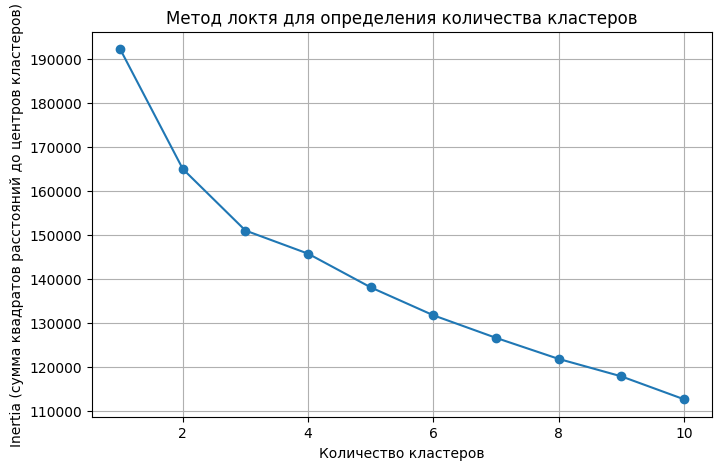

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (сумма квадратов расстояний до центров кластеров)')
plt.title('Метод локтя для определения количества кластеров')
plt.grid(True)
plt.show()


В целях повышения точности предсказания показателя SI мы решили использовать подход кластеризации данных перед обучением моделей. Изначально общие модели, такие как Random Forest и XGBoost, показали невысокое качество предсказаний (MAE и RMSE оставались высокими, а R² был близок к нулю или отрицателен). Это говорит о том, что в данных может существовать скрытая структура, разделяющая молекулы на различные группы, каждая из которых может подчиняться разным закономерностям.

Мы предположили, что в выборке могут быть подгруппы молекул с разной химической природой (например, различной топологией, массой или функциональными группами), и каждая группа может иметь свои особенности взаимосвязи признаков и SI. Чтобы учесть это, мы применили метод кластеризации KMeans для разделения выборки на три подгруппы, основываясь на масштабированных признаках. Затем для каждой подгруппы мы обучили отдельную модель Random Forest и рассчитали метрики качества на тестовой выборке.

Такой подход позволяет адаптировать модель к особенностям каждой подгруппы данных и потенциально улучшить точность предсказаний, что особенно важно в задачах поиска эффективных лекарственных соединений.

На графике метода локтя, построенном для анализа данных, представлена зависимость суммы квадратов расстояний до центров кластеров (Inertia) от количества кластеров. При увеличении числа кластеров значение Inertia постепенно уменьшается, так как каждый новый кластер лучше описывает данные. Однако после определенного момента снижение Inertia замедляется и график «выравнивается», что и образует характерный «локоть».

На представленном графике наиболее отчетливый изгиб локтя наблюдается на отметке 3 кластера. После этого значения Inertia продолжают уменьшаться, но не так значительно, как до этой точки. Это указывает на то, что три кластера достаточно хорошо объясняют структуру данных, и добавление большего количества кластеров даст лишь незначительное улучшение модели.

Таким образом, оптимальное количество кластеров для дальнейшего анализа составляет 3, и мы можем использовать его для сегментации данных перед обучением моделей на каждом кластере.





Кластеры успешно добавлены в таблицу:
   Cluster
0        1
1        1
2        1
3        1
4        1


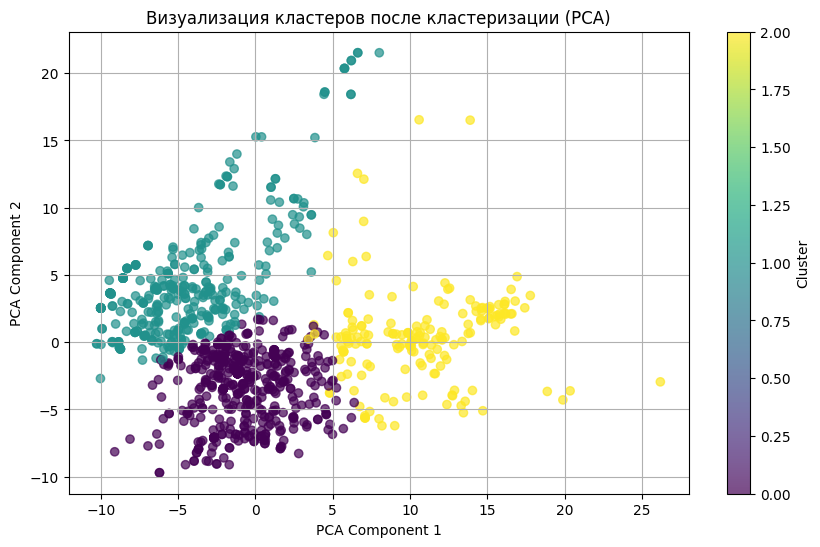

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

optimal_clusters = 3

# Кластеризация
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

print("Кластеры успешно добавлены в таблицу:")
print(df[['Cluster']].head())

#  PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['Cluster'],
    cmap='viridis',
    alpha=0.7
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Визуализация кластеров после кластеризации (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


Графики показывают, что данные действительно разделяются на три группы, причём каждая группа может иметь собственные особенности химической структуры, топологии или других характеристик. Видно, что точки внутри каждого кластера распределены ближе друг к другу, чем между кластерами, что подтверждает целесообразность кластеризации.

In [ ]:
# Количество объектов в каждом кластере
cluster_counts = df['Cluster'].value_counts().sort_index()

# Среднее значение SI в каждом кластере
cluster_si_means = df.groupby('Cluster')['SI'].mean()

# Сводная таблица
cluster_summary = pd.DataFrame({
    'Количество объектов': cluster_counts,
    'Среднее SI': cluster_si_means
})

print("\n Сводная таблица по кластерам:")
display(cluster_summary)



 Сводная таблица по кластерам:


,Количество объектов,Среднее SI
Cluster,,
0,466,112.610869
1,356,51.633741
2,179,9.626005


В результате кластеризации данные были разделены на три кластера. Кластер 0 оказался самым крупным, в него вошли 466 объектов, а его среднее значение показателя SI составило 112.6, что говорит о относительно высокой селективности соединений в этой группе. Кластер 1 включает 356 объектов со средним SI около 51.6 — эта группа характеризуется умеренной активностью соединений. Наименьший кластер 2 содержит 179 объектов с самым низким средним SI — около 9.6, что указывает на низкую эффективность соединений в этой группе. Эти результаты показывают, что каждая группа имеет свои характеристики, и это разделение данных на кластеры может быть полезно для более точного предсказания SI с помощью отдельных моделей для каждой группы.

In [ ]:
key_features = ['MolWt', 'BalabanJ', 'RingCount']
cluster_features_mean = df.groupby('Cluster')[key_features].mean()
print("\n Средние значения ключевых признаков по кластерам:")
display(cluster_features_mean)



 Средние значения ключевых признаков по кластерам:


,MolWt,BalabanJ,RingCount
Cluster,,,
0,314.433590,2.059372,2.927039
1,289.302989,1.777010,3.387640
2,553.589827,1.469737,5.564246


В кластер 2 попали соединения с наибольшей молекулярной массой (среднее MolWt = 553.6) и наибольшим количеством колец (RingCount = 5.56), что может объяснять их низкую эффективность (SI). Кластеры 0 и 1 имеют меньшие значения массы и количества колец, при этом кластер 0 отличается наибольшим средним значением BalabanJ, что может указывать на более сложную топологическую структуру. Эти различия подтверждают, что кластеризация помогает выделить группы соединений с различными структурными особенностями.

In [ ]:
for cluster_label in sorted(df['Cluster'].unique()):
    print(f"Кластер {cluster_label}:")

    cluster_data = df[df['Cluster'] == cluster_label]
    X_cluster = cluster_data.drop(columns=['IC50, mM', 'CC50, mM', 'SI', 'Unnamed: 0', 'Cluster'])
    y_cluster = cluster_data['SI']

    # Импутация NaN
    imputer = SimpleImputer(strategy='median')
    X_cluster_imputed = imputer.fit_transform(X_cluster)

    # Масштабирование признаков
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster_imputed)

    # train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_cluster_scaled, y_cluster, test_size=0.2, random_state=42
    )

    # Логарифмирование целевой переменной
    y_train_log = log_transform(y_train)

    # Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_log)

    # Предсказания
    y_pred_log = model.predict(X_test)
    y_pred = inverse_log_transform(y_pred_log)

    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"  MAE = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R² = {r2:.4f}\n")

    # результаты
    cluster_results.append({
        'Cluster': cluster_label,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })


Кластер 0:
  MAE = 36.9473
  RMSE = 177.3517
  R² = 0.0290

Кластер 1:
  MAE = 22.1577
  RMSE = 62.5715
  R² = 0.1595

Кластер 2:
  MAE = 7.4698
  RMSE = 12.6238
  R² = -0.1883



Обучение отдельных моделей на каждом кластере показало, что предсказания SI в среднем стали более точными, чем при обучении общей модели без кластеризации. Наилучшие результаты достигнуты для кластера 2: модель показала наименьшие ошибки (MAE = 7.47 и RMSE = 12.62), однако отрицательный R² указывает на то, что модель всё же не смогла объяснить вариабельность данных в этой подгруппе лучше, чем простое среднее значение. Для кластера 1 модель достигла умеренных значений ошибок (MAE = 22.16, RMSE = 62.57) и положительного R² (0.16), что свидетельствует о наличии некоторой предсказательной силы. Для кластера 0 метрики остались относительно высокими (MAE = 36.95, RMSE = 177.35), а R² (0.03) всё ещё близок к нулю, что говорит о слабой линейной зависимости в данных этой подгруппы. В целом, разбиение данных на кластеры позволило локально улучшить результаты в некоторых подгруппах, однако задача предсказания SI остаётся достаточно сложной.